# Spaceship titanic

## Import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import neighbors
import torch
from torch import nn
import torch.nn.functional as functional
import copy

## Dataset custom class

In [2]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, pandas_dataframe, y_cols):
        self.ys = pandas_dataframe[y_cols]
        self.xs = pandas_dataframe.drop(y_cols, axis=1)

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        y = self.ys.iloc[idx]
        x = torch.Tensor(np.array(self.xs.iloc[idx]))
        return x, y

## Analysis of the dataframe

In [6]:
for dirname, _, filenames in os.walk('../datas'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../datas/spaceship_titanic_test.csv
../datas/spaceship_titanic_train.csv


In [22]:
og_df = pd.read_csv("../datas/in/spaceship_titanic_train.csv")
og_test_df = pd.read_csv("../datas/in/spaceship_titanic_test.csv")

In [10]:
og_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [11]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


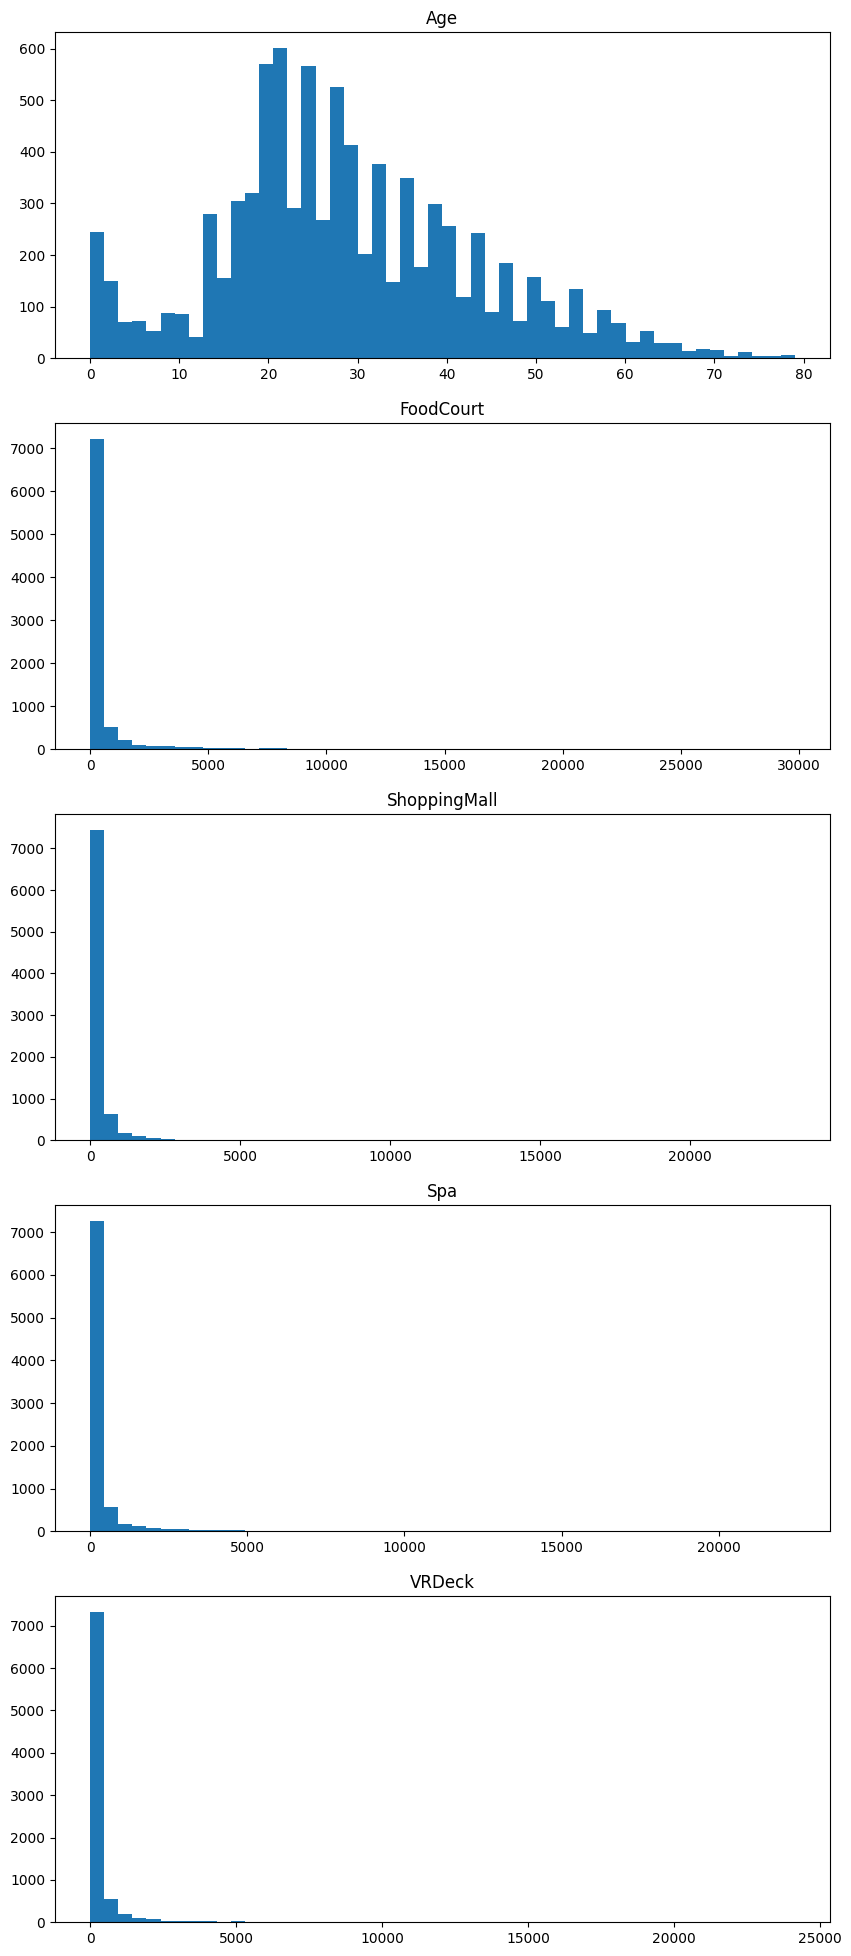

In [12]:
columns = [ 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig, axs = plt.subplots(len(columns),1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)
for i, ax in enumerate(axs):
    ax.set_title(columns[i])
    ax.hist(og_df[columns[i]], bins=50)

In [13]:
og_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Preprocessing

In [23]:
def preprocessing(df):
    new_df = df.drop(['Name'], axis=1)
    new_df = new_df.drop(['PassengerId'], axis=1)
    new_df['CryoSleep'] = pd.to_numeric(new_df['CryoSleep'])
    new_df['VIP'] = pd.to_numeric(new_df['VIP'])
    new_df['Destination'] = pd.factorize(new_df['Destination'])[0]
    new_df['HomePlanet'] = pd.factorize(new_df['HomePlanet'])[0]
    new_df['Cabin'] = pd.factorize(new_df['Cabin'])[0]
    for col in new_df.columns.values:
        new_df[col] = new_df[col].fillna((new_df[col].median()))
    try:
        new_df['Transported'] = new_df['Transported'].astype(float)
    except KeyError:
        pass
        # print("Skipping target column for test dataframe")
    return new_df

In [24]:
df = preprocessing(og_df)
test_df = preprocessing(og_test_df)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,0.0,0,0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,1,0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0
2,0,0.0,2,0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0
3,0,0.0,2,0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0
4,1,0.0,3,0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0


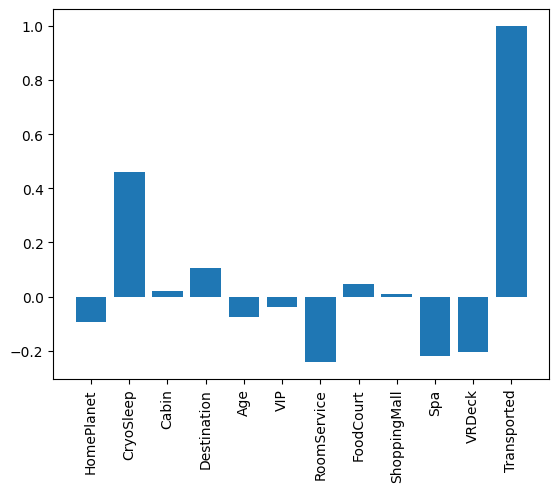

In [25]:
corrs = []
analyze_cols = list(df.columns.values)
for col in analyze_cols:
    corr = df[col].corr(df['Transported'])
    corrs.append(corr)
plt.bar(analyze_cols, corrs)
plt.xticks(rotation=90)
plt.show()

### Preparing data for feeding to models

In [26]:
df_train, df_valid = torch.utils.data.random_split(df, [0.8, 0.2])
dt_train = CustomDataset(df_train.dataset, 'Transported')
dt_valid = CustomDataset(df_valid.dataset, 'Transported')

kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(dt_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dt_valid, **kwargs, shuffle=True)

## Trying models

### KNN

In [27]:
def knn_param_search(train_data, train_labels, test_data, test_labels,
                     metrics=('manhattan', 'euclidean', 'chebyshev'), 
                     ks=(1, 3, 5, 10, 25, 50, 100, 250), algorithm='brute'):
  """
  Takes a dataset and plots knn classification accuracy 
  for different hyper parameters.

  n_train and n_test allows to subsample the dataset for faster iteration
  """
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)
  max_acc = 0
  datas = []
  for metric in metrics:
    for k in ks:
        print(f'Metric: {metric}; k: {k:3};', end=' ')
        classifier = neighbors.KNeighborsClassifier(k, algorithm=algorithm, metric=metric)
        classifier = classifier.fit(x_train, y_train)

        labels = classifier.predict(x_test)
        
        correct = labels == np.array(y_test)
        print(f'Accuracy: {correct.mean() * 100:.2f}%')
        if correct.mean() > max_acc:
          max_acc = correct.mean()
          best_classifier = classifier
          best_metric = metric
          best_k = k
        datas.append([metric, k, correct.mean()])
      
  print(f'Best classifier | metric: {best_metric}; k: {best_k:3}; accuracy: {max_acc * 100:.2f}%')
  return best_classifier, datas

In [28]:
classifier, data = knn_param_search(dt_train.xs.values, dt_train.ys.values, dt_valid.xs.values, dt_valid.ys.values, ks=[1], metrics=['manhattan'])
# classifier, data = knn_param_search(dt_train.xs.values, dt_train.ys.values, dt_valid.xs.values, dt_valid.ys.values,)
X_test = test_df.values
predictions = classifier.predict(X_test)

Metric: manhattan; k:   1; Accuracy: 99.94%
Best classifier | metric: manhattan; k:   1; accuracy: 99.94%


#### Result generation

In [31]:
og_test_df['Transported'] = predictions.astype(bool)
result = og_test_df.iloc[:, [0, -1]]
result.to_csv('../datas/out/knn_results.csv', index=False)

### MLP

In [32]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int, lenght_x: int, output_layer_lenght: int):
    super().__init__()
    self.fc1 = nn.Linear(lenght_x, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, output_layer_lenght)

  def forward(self, x: torch.Tensor):
    x = x.flatten(start_dim=1)
    h = functional.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

In [48]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

epochs = 50
lrs = [1e-3]
hidden_neurons = [1000, 10000, 50000]
for lr in lrs:
    for n_hidden_neurons in hidden_neurons:
        model = MLP(n_hidden_neurons, len(dt_train.xs.iloc[0]), 2)
        opt = torch.optim.SGD(model.parameters(), lr=lr)
        train_losses, train_accuracies = [], []
        valid_losses, valid_accuracies = [], []
        for epoch in range(epochs):
            print(f"Learning rate: {lr}; N hidden neurons: {n_hidden_neurons}; Epoch: {epoch+1}/{epochs}", end='\r')
            # train
            epoch_losses = []
            correct, total = 0, 0
            for x, y in loader_train:
                y = y.type(torch.LongTensor)
                opt.zero_grad()
                logits = model(x)  # logits: common name for the output before softmax activation
                log_probs = functional.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
                loss = functional.nll_loss(log_probs, y)  # negative log likelihood loss
                # or just: loss = F.cross_entropy(logits, y)
                
                loss.backward()
                opt.step()
                
                epoch_losses.append(loss.item())
                total += len(x)
                correct += (torch.argmax(logits, dim=1) == y).sum().item()
            train_losses.append(np.mean(epoch_losses))
            train_accuracies.append(correct / total)
            
            # valid
            epoch_losses = []
            correct, total = 0, 0
            for x, y in loader_valid:
                y = y.type(torch.LongTensor)
                with torch.no_grad():
                    logits = model(x)
                loss = functional.cross_entropy(logits, y)

                epoch_losses.append(loss.item())
                total += len(x)
                correct += (torch.argmax(logits, dim=1) == y).sum().item()
            valid_losses.append(np.mean(epoch_losses))
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)
            
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_model = copy.deepcopy(model), n_hidden_neurons, epoch
        print("\n" + "-"*100)        
        all_losses[str(lr) + " " + str(n_hidden_neurons)] = train_losses, valid_losses
        all_accuracies[str(lr) + " " + str(n_hidden_neurons)] = train_accuracies, valid_accuracies


Learning rate: 0.001; N hidden neurons: 1000; Epoch: 50/50
----------------------------------------------------------------------------------------------------
Learning rate: 0.001; N hidden neurons: 10000; Epoch: 50/50
----------------------------------------------------------------------------------------------------
Learning rate: 0.001; N hidden neurons: 50000; Epoch: 50/50
----------------------------------------------------------------------------------------------------


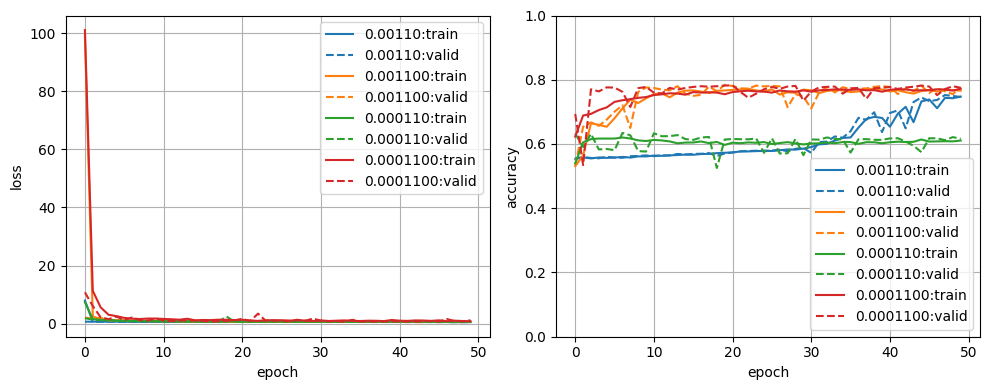

In [47]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [43]:
best_model

(MLP(
   (fc1): Linear(in_features=11, out_features=1000, bias=True)
   (fc2): Linear(in_features=1000, out_features=2, bias=True)
 ),
 1000,
 47)